# Cell-free and in vivo characterization of LuxR, LasR, and RpaR activation Systems 
## Data anlysis notebook 

This jupyter notebook serves to reproduce all of the figures published in "Cell-free and in vivo characterization of LuxR, LasR, and RpaR activation systems" by Halleran and Murray, 2017. 

All analysis is performed in Python 3.5 using Anaconda. 

All data can be found in the Data directory of this git repository. All plate maps can be found in Data/Maps. 

In [1]:
# First we are going to import all of the packages we need for the entirety of the notebook. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
# This sets default backgrounds for our seaborn plots to make them look a bit nicer. 
rcParams.update({'figure.autolayout': True})
rc={'lines.linewidth': 4, 'axes.labelsize': 30, 'axes.titlesize': 24}

First we want to recreate figure 1, part A through D. 

Figure 1A is a time trace off a BioTek H1M. The data for this file is in /Data/170529_RpaR_CT_Trial_tidy.csv. 

Below we are going to write a function for taking a series of wells and plotting a linegraph with standard deviation. Then we are going to pass in all of our wells from the figure and create a formatted plot at the end. 

## Figure 1A 

In [38]:
def plotWells(wells, gain, tag, color):
    ''' Takes a set of wells from the BioTek data that are biological replicates and generates a plot
        with the mean as a solid line and +/- standard deviation shaded. 
        Function takes a list of wells, wells, the gain of interest for each well (string), the tag (label) to be plotted,
        and the color you want the line to be, passed as a string interpretable by matplotlib. '''
    
    # Create a list to hold all of the data from each well. 
    allWells = []
    
    # Iterate over each well that was passed
    for well in wells: 
        # Slice the data frame by well
        wellData = flxData[flxData['Well'] == well]
        # Select the appropriate gain that was passed
        wellData = wellData[wellData['Gain'] == gain]
        # Get the corresponding time stamp for each data point
        time = wellData.loc[:, 'Time (hr)']
        # Append all of the micromolar concentrations of fluorescence to allWells
        allWells.append(wellData.uM)
    
    # Make an array from allWells
    wellArray = (allWells[0], allWells[1], allWells[2], allWells[3])
    # Get the mean across the four biological replicates at each timepoint
    mean = np.mean(wellArray, axis=0)
    # Calculate the standard deviation across the four biological replicates at each timepoint
    std = np.std(wellArray, axis=0)
    # Create the boundary for the below mean shading
    below_mean = np.subtract(mean, std)
    # Create the boundary for the above mean shading
    above_mean = np.add(mean, std)
    # Create the shaded region
    plt.fill_between(time, below_mean, above_mean, alpha=0.4, color=color)
    # Create the line plot
    plt.plot(time, mean, color=color, label=tag)

Now we are going to load in our fluorescence data from the BioTek. We are using already tidy format data, for a package to tidy raw data please see github.com/sclamons/murraylab_tools 

In [39]:
# Read in fluorescence data into a pandas dataframe
flxData = pd.read_csv('Data/170529_RpaR_CT_Trial_tidy.csv')

For this plot we want to plot RpaR with pRpa with different concentrations of Rpa ligand (p-coumaroyl). Those wells are: 
I-P, 9-12. Each row is a different amount of AHL, each column is a replicate experiment. I is the negative control (DMSO only), and then we go from high concentraiton (100uM) in J to low concentration in P. 

Let's plot that out. 

/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


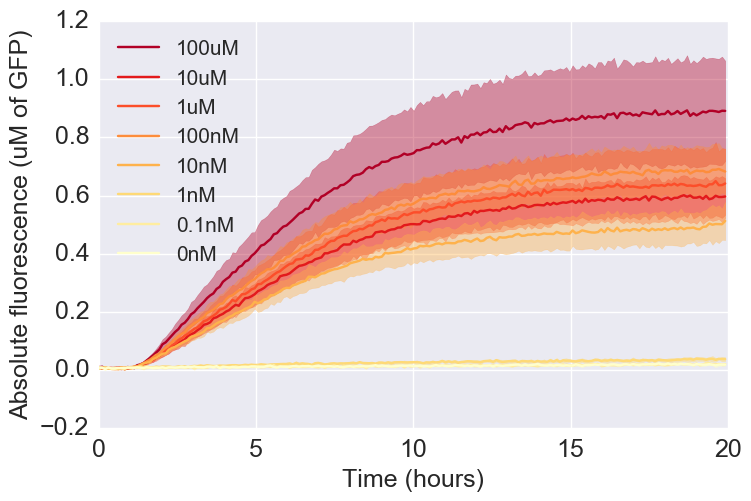

In [40]:
# Identify the wells we want to plot 
well1 = '9'
well2 = '10'
well3 = '11'
well4 = '12'

# Call the plotWells function for each experimental group we want to plot
plotWells(['J' + well1, 'J' + well2, 'J' + well3, 'J' + well4], 61, '100uM', '#b10026')
plotWells(['K' + well1, 'K' + well2, 'K' + well3, 'K' + well4], 61, '10uM', '#e31a1c')
plotWells(['L' + well1, 'L' + well2, 'L' + well3, 'L' + well4], 61, '1uM', '#fc4e2a')
plotWells(['M' + well1, 'M' + well2, 'M' + well3, 'M' + well4], 61, '100nM', '#fd8d3c')
plotWells(['N' + well1, 'N' + well2, 'N' + well3, 'N' + well4], 61, '10nM', '#feb24c')
plotWells(['O' + well1, 'O' + well2, 'O' + well3, 'O' + well4], 61, '1nM', '#fed976')
plotWells(['P' + well1, 'P' + well2, 'P' + well3, 'P' + well4], 61, '0.1nM', '#ffeda0')
plotWells(['I' + well1, 'I' + well2, 'I' + well3, 'I' + well4], 61, '0nM', '#ffffcc')


# Format the plot to make it a little bit cleaner
plt.xlabel('Time (hours)', fontsize=18)
plt.ylabel('Absolute fluorescence (uM of GFP)', fontsize=18)
plt.legend(loc='upper left', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

## Figures 1B-D

Now that we have an example trace the next thing we want to look at is crosstalk heatmaps from our TX-TL data. This is going to consist of four main steps:
    1. Calculate the maximum fluorescence across the time series 
    2. Subtract background fluorescence
    3. Normalize all measurements for a given transcription factor to the highest expression observed
    4. Plot the heatmap
    
Figure 1B is LuxR data, so we're going to first load that in

In [41]:
# Read in fluorescence data into a pandas dataframe
flxData = pd.read_csv('Data/170526_LuxR_CT_Trial_Tidy.csv')

Now we are going to use a function that will return the 95th percentile value across a given time series. 

Because we have replicates (N=4 for all TX-TL crosstalk experiments), we are going to pass the four wells we are interested in to the function and it is going to return the mean of the 95th percentiles for each of the four wells. 


In [42]:
def get95(wells, gain, negativeControl=0):
    ''' Takes a list of wells (list), a gain (str), and optionally a negative control value (numeric). If no
    negative control value is given it is defaulted to 0. 
    The function takes a set of wells and for each well calculates the 95th percentile fluorescence value. 
    It then averages those fluorescence values and subtracts your negative control value to generate a background-
    subtracted maximum fluorescence for each group of wells. It then returns this value. '''
    
    # Initialize empty list of percentileValues
    percentileValues = []
    # Iterate over all wells passed, append the 95th percentile value from each well to the list of all 
    # 95th percentiles
    for well in wells: 
        # Slice dataframe by well
        wellData = flxData[flxData['Well'] == well]
        # Slice dataframe by gain
        wellData = wellData[wellData['Gain'] == gain]
        # Use numpy to grab the 95th percentile value from our list of uM values
        maxFlx = np.percentile(wellData.uM.values, 95)
        # Add each value to the list
        percentileValues.append(maxFlx)
        
    # Return the mean background-subtracted value across all wells passed
    return np.mean(np.array(percentileValues))-negativeControl



In [43]:
# First we want to run this function for each of the three negative controls. 
LuxR_pLux_neg = get95(['H13', 'H14', 'H15', 'H16'], 61)
LuxR_pLas_neg = get95(['H1', 'H2', 'H3', 'H4'], 61)
LuxR_pRpa_neg = get95(['P1', 'P2', 'P3', 'P4'], 61)

# Now we're going to run this function for the nine condtions we need
LuxR_pLux_LuxAHL = get95(['D13', 'D14', 'D15', 'D16'], 61, LuxR_pLux_neg)
LuxR_pLux_LasAHL = get95(['D17', 'D18', 'D19', 'D20'], 61, LuxR_pLux_neg)
LuxR_pLux_RpaAHL = get95(['D21', 'D22', 'D23', 'D24'], 61, LuxR_pLux_neg)
LuxR_pLas_LuxAHL = get95(['D1', 'D2', 'D3', 'D4'], 61, LuxR_pLas_neg)
LuxR_pLas_LasAHL = get95(['D5', 'D6', 'D7', 'D8'], 61, LuxR_pLas_neg)
LuxR_pLas_RpaAHL = get95(['D9', 'D10', 'D11', 'D12'], 61, LuxR_pLas_neg)
LuxR_pRpa_LuxAHL = get95(['L1', 'L2', 'L3', 'L4'], 61, LuxR_pRpa_neg)
LuxR_pRpa_LasAHL = get95(['L5', 'L6', 'L7', 'L8'], 61, LuxR_pRpa_neg)
LuxR_pRpa_RpaAHL = get95(['L9', 'L10', 'L11', 'L12'], 61, LuxR_pRpa_neg)

In [44]:
# Nowe we want to assemble our 2d Array for plotting with seaborn's heatmap plot. We are going to remove any negative
# values (artifacts from background subtraction) by using np.clip(0) which will replace any negative value with 0. 
firstRow = np.array([LuxR_pLux_LuxAHL, LuxR_pLux_LasAHL, LuxR_pLux_RpaAHL]).clip(0)
secondRow = np.array([LuxR_pLas_LuxAHL, LuxR_pLas_LasAHL, LuxR_pLas_RpaAHL]).clip(0)
thirdRow = np.array([LuxR_pRpa_LuxAHL, LuxR_pRpa_LasAHL, LuxR_pRpa_RpaAHL]).clip(0)

# Now we build our 2d array by combining firstRow, secondRow, and thirdRow
heatmapVector = [firstRow, secondRow, thirdRow]

# And finally we normalize the 2d Array by the maximum value in the array and round each entry to 2 decimal points
heatmapVector = np.around(np.divide([firstRow, secondRow, thirdRow], np.amax(heatmapVector)), 2)

/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


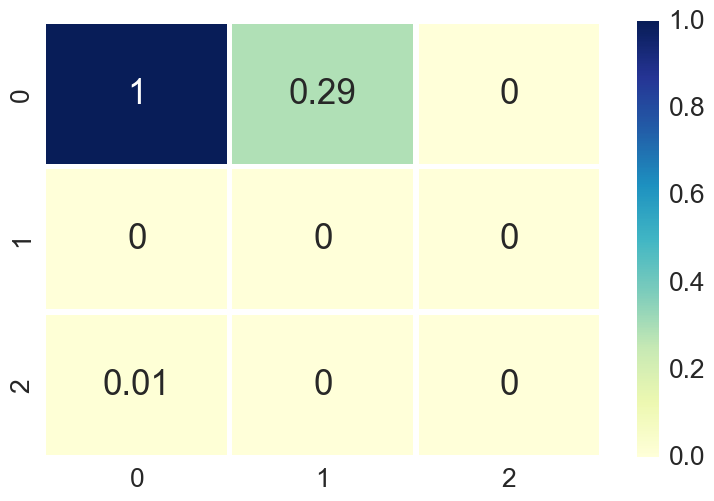

In [45]:
# Plot out the normalized heatmap. 
ax = sns.heatmap(heatmapVector, annot=True, annot_kws={'size':25}, linewidths =3, cmap="YlGnBu", vmin=0, vmax=1)
sns.set(font_scale=1.9)
plt.show()

We'll fix the labels in photoshop, but this is the core of figure 1B. Time to make the same graphs but for 1C, and 1D. 

1C is LasR data so we need to load in a new file. Once we do that we are going to run almost exactly what we did above for figure 1B. 

In [46]:
# Load in the flx data for LasR 
flxData = pd.read_csv('Data/170530_LasR_CT_Trial_Tidy.csv')

/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


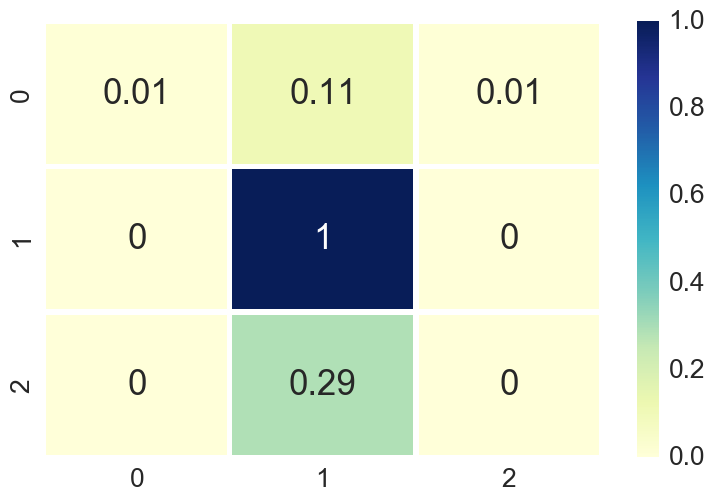

In [47]:
# First we want to run this function for each of the three negative controls. 
LasR_pLux_neg = get95(['H5', 'H6', 'H7', 'H8'], 61)
LasR_pLas_neg = get95(['H17', 'H18', 'H19', 'H20'], 61)
LasR_pRpa_neg = get95(['P5', 'P6', 'P7', 'P8'], 61)

# Now we're going to run this function for the nine condtions we need
LasR_pLux_LuxAHL = get95(['D1', 'D2', 'D3', 'D4'], 61, LasR_pLux_neg)
LasR_pLux_LasAHL = get95(['D5', 'D6', 'D7', 'D8'], 61, LasR_pLux_neg)
LasR_pLux_RpaAHL = get95(['D9', 'D10', 'D11', 'D12'], 61, LasR_pLux_neg)
LasR_pLas_LuxAHL = get95(['D13', 'D14', 'D15', 'D16'], 61, LasR_pLas_neg)
LasR_pLas_LasAHL = get95(['D17', 'D18', 'D19', 'D20'], 61, LasR_pLas_neg)
LasR_pLas_RpaAHL = get95(['D21', 'D22', 'D23', 'D24'], 61, LasR_pLas_neg)
LasR_pRpa_LuxAHL = get95(['L1', 'L2', 'L3', 'L4'], 61, LasR_pRpa_neg)
LasR_pRpa_LasAHL = get95(['L5', 'L6', 'L7', 'L8'], 61, LasR_pRpa_neg)
LasR_pRpa_RpaAHL = get95(['L9', 'L10', 'L11', 'L12'], 61, LasR_pRpa_neg)

# Nowe we want to assemble our 2d Array for plotting with seaborn's heatmap plot. We are going to remove any negative
# values (artifacts from background subtraction) by using np.clip(0) which will replace any negative value with 0. 
firstRow = np.array([LasR_pLux_LuxAHL, LasR_pLux_LasAHL, LasR_pLux_RpaAHL]).clip(0)
secondRow = np.array([LasR_pLas_LuxAHL, LasR_pLas_LasAHL, LasR_pLas_RpaAHL]).clip(0)
thirdRow = np.array([LasR_pRpa_LuxAHL, LasR_pRpa_LasAHL, LasR_pRpa_RpaAHL]).clip(0)

# Now we build our 2d array by combining firstRow, secondRow, and thirdRow
heatmapVector = [firstRow, secondRow, thirdRow]

# And finally we normalize the 2d Array by the maximum value in the array and round each entry to 2 decimal points
heatmapVector = np.around(np.divide([firstRow, secondRow, thirdRow], np.amax(heatmapVector)), 2)

# Plot out the normalized heatmap. 
ax = sns.heatmap(heatmapVector, annot=True, annot_kws={'size':25}, linewidths =3, cmap="YlGnBu", vmin=0, vmax=1)
plt.show()

In [48]:
# Load in the RpaR data
flxData = flxData = pd.read_csv('Data/170529_RpaR_CT_Trial_Tidy.csv')

/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


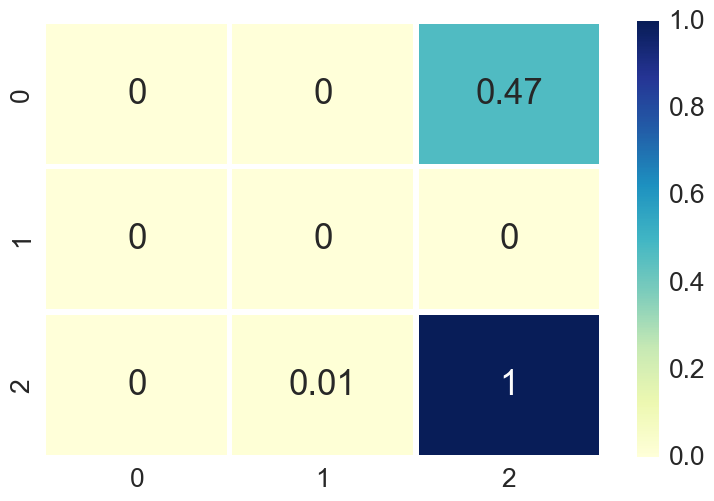

In [49]:
# First we want to run this function for each of the three negative controls. 
RpaR_pLux_neg = get95(['H9', 'H10', 'H11', 'H12'], 61)
RpaR_pLas_neg = get95(['H21', 'H22', 'H23', 'H24'], 61)
RpaR_pRpa_neg = get95(['P9', 'P10', 'P11', 'P12'], 61)

# Now we're going to run this function for the nine condtions we need
RpaR_pLux_LuxAHL = get95(['D1', 'D2', 'D3', 'D4'], 61, RpaR_pLux_neg)
RpaR_pLux_LasAHL = get95(['D5', 'D6', 'D7', 'D8'], 61, RpaR_pLux_neg)
RpaR_pLux_RpaAHL = get95(['D9', 'D10', 'D11', 'D12'], 61, RpaR_pLux_neg)
RpaR_pLas_LuxAHL = get95(['D13', 'D14', 'D15', 'D16'], 61, RpaR_pLas_neg)
RpaR_pLas_LasAHL = get95(['D17', 'D18', 'D19', 'D20'], 61, RpaR_pLas_neg)
RpaR_pLas_RpaAHL = get95(['D21', 'D22', 'D23', 'D24'], 61, RpaR_pLas_neg)
RpaR_pRpa_LuxAHL = get95(['L1', 'L2', 'L3', 'L4'], 61, RpaR_pRpa_neg)
RpaR_pRpa_LasAHL = get95(['L5', 'L6', 'L7', 'L8'], 61, RpaR_pRpa_neg)
RpaR_pRpa_RpaAHL = get95(['L9', 'L10', 'L11', 'L12'], 61, RpaR_pRpa_neg)

# Nowe we want to assemble our 2d Array for plotting with seaborn's heatmap plot. We are going to remove any negative
# values (artifacts from background subtraction) by using np.clip(0) which will replace any negative value with 0. 
firstRow = np.array([RpaR_pLux_LuxAHL, RpaR_pLux_LasAHL, RpaR_pLux_RpaAHL]).clip(0)
secondRow = np.array([RpaR_pLas_LuxAHL, RpaR_pLas_LasAHL, RpaR_pLas_RpaAHL]).clip(0)
thirdRow = np.array([RpaR_pRpa_LuxAHL, RpaR_pRpa_LasAHL, RpaR_pRpa_RpaAHL]).clip(0)

# Now we build our 2d array by combining firstRow, secondRow, and thirdRow
heatmapVector = [firstRow, secondRow, thirdRow]

# And finally we normalize the 2d Array by the maximum value in the array and round each entry to 2 decimal points
heatmapVector = np.around(np.divide([firstRow, secondRow, thirdRow], np.amax(heatmapVector)), 2)

# Plot out the normalized heatmap. 
ax = sns.heatmap(heatmapVector, annot=True, annot_kws={'size':25}, linewidths =3, cmap="YlGnBu", vmin=0, vmax=1)
plt.show()

## Figure 2A-C

Now that we have reproduced figure 1, subplots A-D, we can move on to figure 2. 

The first set of figures we're going to make are the in vivo crosstalk heatmaps. These are going to be very similar to the plots provided above, but now we need to normalize our GFP readings by OD before we can create our heatmap. Our negative control well for these experiments is a set of three wells (each a distinct colony) that instead of being induced by an AHL are in media containing the same final % of DMSO. 

However, our main steps are still very similar to what they were above. Briefly: 

    1. Calculate the maximum fluorescence / OD across the time series
    2. Subtract background fluorescence (calculated from DMSO only wells) 
    3. Normalize all measurements for a given transcription factor to the highest expression observed
    4. Plot the heatmap

We're going to start with LuxR data, as before. This experiment was split across two different BioTeks which means we have two files we need to pull from, and two different sets of negative control wells. That makes the analysis code a bit longer, but same exact concept as what's going to follow for 2B and 2C. 

In [50]:
flxData1 = pd.read_csv('Data/170601_invivo_CT_panel_Tidy.csv')
flxData2 = pd.read_csv('Data/170613_LuxR_pLas_CT_experiment_tidy.csv')

In [51]:
def get95_ODNormalized(wells, gain1, gain2, dataFile, negativeControl=0):
    ''' Takes a list of wells (list), a gain1 (str), a gain2 (str), a datafile (str),
    and optionally a negative control value (numeric). If no negative control value is given it is defaulted to 0. 
    The function takes a set of wells and for each well calculates the 95th percentile of OD normalize fluorescence, 
    where gain1 is the data you want normalized and gain2 is what you want it normalized by. 
    It then averages those fluorescence values and subtracts your negative control value to generate a background-
    subtracted maximum fluorescence/OD for each group of wells. It then returns this value. ''' 
    
    percentileValues = []
    # Iterate over all wells passed, append the 95th percentile value from each well to the list of all 
    # 95th percentiles
    for well in wells: 
        # Slice the wellData by well
        wellData = dataFile[dataFile['Well'] == well]
        # Get the GFP by slicing out gain1
        wellDataGFP = wellData[wellData['Gain'] == gain1]
        # Get the OD data by slicing out gain2
        wellDataOD = wellData[wellData['Gain']==gain2]
        # Normalize GFP values by OD
        wellDataGFPNorm = (wellDataGFP.AFU.values)/(wellDataOD.AFU.values)
        # Get the 95th percentile of that dataset
        maxFlx = np.percentile(wellDataGFPNorm, 95)
        # Append it to the list of percentiles
        percentileValues.append(maxFlx)
    # Return the mean of our background-subtracted samples
    return np.mean(np.array(percentileValues))-negativeControl

# Calculate all of our negative controls
LuxR_pLux_neg = get95_ODNormalized(['A10', 'A11', 'A12'], 61, -1, flxData1)
LuxR_pLas_neg = get95_ODNormalized(['D10', 'D11', 'D12'], 61, -1, flxData2)
LuxR_pRpa_neg = get95_ODNormalized(['B10', 'B11', 'B12'], 61, -1, flxData1)
LasR_pLux_neg = get95_ODNormalized(['C10', 'C11', 'C12'], 61, -1, flxData1)
LasR_pLas_neg = get95_ODNormalized(['D10', 'D11', 'D12'], 61, -1, flxData1)
LasR_pRpa_neg = get95_ODNormalized(['E10', 'E11', 'E12'], 61, -1, flxData1)
RpaR_pLux_neg = get95_ODNormalized(['F10', 'F11', 'F12'], 61, -1, flxData1)
RpaR_pLas_neg = get95_ODNormalized(['G10', 'G11', 'G12'], 61, -1, flxData1)
RpaR_pRpa_neg = get95_ODNormalized(['H10', 'H11', 'H12'], 61, -1, flxData1)

/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


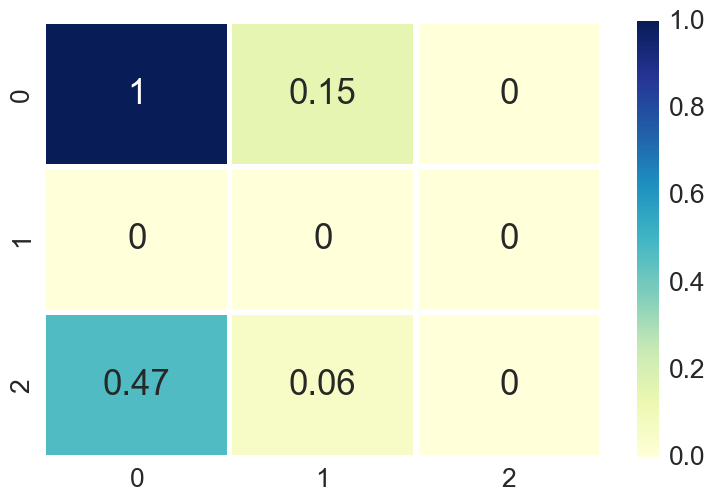

In [52]:
# Now that we have all of our negative control values we can get our experimental data results. 
# First plot is again for LuxR. 

LuxR_pLux_LuxAHL = get95_ODNormalized(['A1', 'A2', 'A3'], 61, -1, flxData1, LuxR_pLux_neg)
LuxR_pLux_LasAHL = get95_ODNormalized(['A4', 'A5', 'A6'], 61, -1, flxData1, LuxR_pLux_neg)
LuxR_pLux_RpaAHL = get95_ODNormalized(['A7', 'A8', 'A9'], 61, -1, flxData1, LuxR_pLux_neg)
LuxR_pLas_LuxAHL = get95_ODNormalized(['D1', 'D2', 'D3'], 61, -1, flxData2, LuxR_pLas_neg)
LuxR_pLas_LasAHL = get95_ODNormalized(['D4', 'D5', 'D6'], 61, -1, flxData2, LuxR_pLas_neg)
LuxR_pLas_RpaAHL = get95_ODNormalized(['D7', 'D8', 'D9'], 61, -1, flxData2, LuxR_pLas_neg)
LuxR_pRpa_LuxAHL = get95_ODNormalized(['B1', 'B2', 'B3'], 61, -1, flxData1, LuxR_pRpa_neg)
LuxR_pRpa_LasAHL = get95_ODNormalized(['B4', 'B5', 'B6'], 61, -1, flxData1, LuxR_pRpa_neg)
LuxR_pRpa_RpaAHL = get95_ODNormalized(['B7', 'B8', 'B9'], 61, -1, flxData1, LuxR_pRpa_neg)

# Nowe we want to assemble our 2d Array for plotting with seaborn's heatmap plot. 
firstRow = np.array([LuxR_pLux_LuxAHL, LuxR_pLux_LasAHL, LuxR_pLux_RpaAHL]).clip(0)
secondRow = np.array([LuxR_pLas_LuxAHL, LuxR_pLas_LasAHL, LuxR_pLas_RpaAHL]).clip(0)
thirdRow = np.array([LuxR_pRpa_LuxAHL, LuxR_pRpa_LasAHL, LuxR_pRpa_RpaAHL]).clip(0)

heatmapVector = [firstRow, secondRow, thirdRow]
heatmapVector = np.around(np.divide([firstRow, secondRow, thirdRow], np.amax(heatmapVector)), 2)

# Plot out the normalized heatmap. 
ax = sns.heatmap(heatmapVector, annot=True, annot_kws={'size':25}, linewidths =3, cmap="YlGnBu", vmin=0, vmax=1)
plt.show()

/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


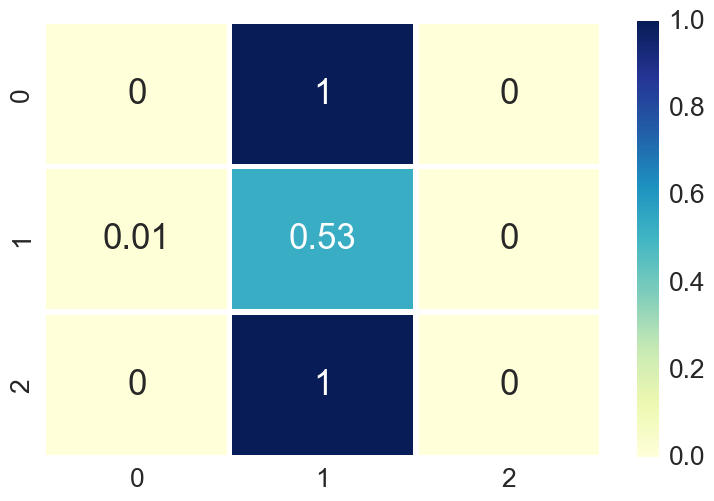

In [53]:
# Time to do the same for LasR
LasR_pLux_LuxAHL = get95_ODNormalized(['C1', 'C2', 'C3'], 61, -1, flxData1, LasR_pLux_neg)
LasR_pLux_LasAHL = get95_ODNormalized(['C4', 'C5', 'C6'], 61, -1, flxData1, LasR_pLux_neg)
LasR_pLux_RpaAHL = get95_ODNormalized(['C7', 'C8', 'C9'], 61, -1, flxData1, LasR_pLux_neg)
LasR_pLas_LuxAHL = get95_ODNormalized(['D1', 'D2', 'D3'], 61, -1, flxData1, LasR_pLas_neg)
LasR_pLas_LasAHL = get95_ODNormalized(['D4', 'D5', 'D6'], 61, -1, flxData1, LasR_pLas_neg)
LasR_pLas_RpaAHL = get95_ODNormalized(['D7', 'D8', 'D9'], 61, -1, flxData1, LasR_pLas_neg)
LasR_pRpa_LuxAHL = get95_ODNormalized(['E1', 'E2', 'E3'], 61, -1, flxData1, LasR_pRpa_neg)
LasR_pRpa_LasAHL = get95_ODNormalized(['E4', 'E5', 'E6'], 61, -1, flxData1, LasR_pRpa_neg)
LasR_pRpa_RpaAHL = get95_ODNormalized(['E7', 'E8', 'E9'], 61, -1, flxData1, LasR_pRpa_neg)

# Nowe we want to assemble our 2d Array for plotting with seaborn's heatmap plot. 
firstRow = np.around(np.array([LasR_pLux_LuxAHL, LasR_pLux_LasAHL, LasR_pLux_RpaAHL]).clip(0), decimals=2)
secondRow = np.around(np.array([LasR_pLas_LuxAHL, LasR_pLas_LasAHL, LasR_pLas_RpaAHL]).clip(0), decimals=2)
thirdRow = np.around(np.array([LasR_pRpa_LuxAHL, LasR_pRpa_LasAHL, LasR_pRpa_RpaAHL]).clip(0), decimals=2)

heatmapVector = [firstRow, secondRow, thirdRow]
heatmapVector = np.around(np.divide([firstRow, secondRow, thirdRow], np.amax(heatmapVector)), decimals=2)

# Plot out the normalized heatmap. 
ax = sns.heatmap(heatmapVector, annot=True, annot_kws={'size':25}, linewidths =3, cmap="YlGnBu", vmin=0, vmax=1)
plt.show()


/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


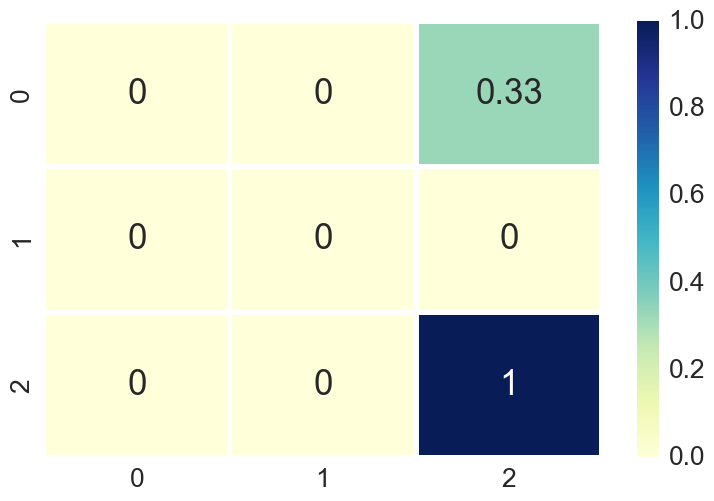

In [54]:
# Time to do the same for RpaR
RpaR_pLux_LuxAHL = get95_ODNormalized(['F1', 'F2', 'F3'], 61, -1, flxData1, RpaR_pLux_neg)
RpaR_pLux_LasAHL = get95_ODNormalized(['F4', 'F5', 'F6'], 61, -1, flxData1, RpaR_pLux_neg)
RpaR_pLux_RpaAHL = get95_ODNormalized(['F7', 'F8', 'F9'], 61, -1, flxData1, RpaR_pLux_neg)
RpaR_pLas_LuxAHL = get95_ODNormalized(['G1', 'G2', 'G3'], 61, -1, flxData1, RpaR_pLas_neg)
RpaR_pLas_LasAHL = get95_ODNormalized(['G4', 'G5', 'G6'], 61, -1, flxData1, RpaR_pLas_neg)
RpaR_pLas_RpaAHL = get95_ODNormalized(['G7', 'G8', 'G9'], 61, -1, flxData1, RpaR_pLas_neg)
RpaR_pRpa_LuxAHL = get95_ODNormalized(['H1', 'H2', 'H3'], 61, -1, flxData1, RpaR_pRpa_neg)
RpaR_pRpa_LasAHL = get95_ODNormalized(['H4', 'H5', 'H6'], 61, -1, flxData1, RpaR_pRpa_neg)
RpaR_pRpa_RpaAHL = get95_ODNormalized(['H7', 'H8', 'H9'], 61, -1, flxData1, RpaR_pRpa_neg)

# Nowe we want to assemble our 2d Array for plotting with seaborn's heatmap plot. 
firstRow = np.array([RpaR_pLux_LuxAHL, RpaR_pLux_LasAHL, RpaR_pLux_RpaAHL]).clip(0)
secondRow = np.array([RpaR_pLas_LuxAHL, RpaR_pLas_LasAHL, RpaR_pLas_RpaAHL]).clip(0)
thirdRow = np.array([RpaR_pRpa_LuxAHL, RpaR_pRpa_LasAHL, RpaR_pRpa_RpaAHL]).clip(0)

heatmapVector = [firstRow, secondRow, thirdRow]
heatmapVector = np.around(np.divide([firstRow, secondRow, thirdRow], np.amax(heatmapVector)), decimals = 2)

# Plot out the normalized heatmap. 
ax = sns.heatmap(heatmapVector, annot=True, annot_kws={'size':25}, linewidths =3, cmap="YlGnBu", vmin=0, vmax=1)
plt.show()

## Figure 2D-E

Now we have created the plots for TX-TL traces, TX-TL crosstalk, and in vivo crosstalk. Now we are going to move on to the final two figures which examine the impact of the TF : Reporter DNA ratio for TX-TL mapping. 

The code is very similar to what we used above. Again we are going to get the maximum value out of a timeseries. This is then going to be normalized to the signal of pLux for that given TF concentration. 

In [55]:
flxData = pd.read_csv('Data/170612_Genetic_CT_Titration_tidy.csv')

In [56]:
def get95_Replicates(wells, gain):
    
    ''' Takes a list of wells and a specified gain. Returns the an array with the 95th percentile 
        from each well. '''
    
    # Initialize list of percentile values
    percentileValues = []
    # Iterate over all wells passed, append the 95th percentile value from each well to the list of all 
    # 95th percentiles
    for well in wells: 
        wellData = flxData[flxData['Well'] == well]
        wellData = wellData[wellData['Gain'] == gain]
        maxFlx = np.percentile(wellData.uM.values, 95)
        percentileValues.append(maxFlx)
    # Return numpy array of percentile values
    return np.array(percentileValues)


# Get the pLux_1nM values, and normalize them by pLux_1nM values
pLux_1nM = get95_Replicates(['A1', 'A2', 'A3'], 61)
pLux_1nM = np.divide(pLux_1nM, np.mean(pLux_1nM))

# Get the pLux_2nM values, and normalize them by pLux_2nM values
pLux_2nM = get95_Replicates(['B1', 'B2', 'B3'], 61)
pLux_2nM = np.divide(pLux_2nM, np.mean(pLux_2nM))

# Get the pLux_4nM values, and normalize them by pLux_4nM values
pLux_4nM = get95_Replicates(['C1', 'C2', 'C3'], 61)
pLux_4nM = np.divide(pLux_4nM, np.mean(pLux_4nM))

# Get the pLux_8nM values, and normalize them by pLux_8nM values
pLux_8nM = get95_Replicates(['D1', 'D2', 'D3'], 61)
pLux_8nM = np.divide(pLux_8nM, np.mean(pLux_8nM))

# Get the pLux_16nM values, and normalize them by pLux_16nM values
pLux_16nM = get95_Replicates(['E1', 'E2', 'E3'], 61)
pLux_16nM = np.divide(pLux_16nM, np.mean(pLux_16nM))

# Get the pLas_1nM values, and normalize them by pLux_1nM values
pLas_1nM = get95_Replicates(['A4', 'A5', 'A6'], 61)
pLas_1nM = np.divide(pLas_1nM, np.mean(pLux_1nM))

# Get the pLas_2nM values, and normalize them by pLux_2nM values
pLas_2nM = get95_Replicates(['B4', 'B5', 'B6'], 61)
pLas_2nM = np.divide(pLas_2nM, np.mean(pLux_2nM))

# Get the pLas_4nM values, and normalize them by pLux_4nM values
pLas_4nM = get95_Replicates(['C4', 'C5', 'C6'], 61)
pLas_4nM = np.divide(pLas_4nM, np.mean(pLux_4nM))

# Get the pLas_8nM values, and normalize them by pLux_8nM values
pLas_8nM = get95_Replicates(['D4', 'D5', 'D6'], 61)
pLas_8nM = np.divide(pLas_8nM, np.mean(pLux_8nM))

# Get the pLas_16nM values, and normalize them by pLux_16nM values
pLas_16nM = get95_Replicates(['E4', 'E5', 'E6'], 61)
pLas_16nM = np.divide(pLas_16nM, np.mean(pLux_16nM))

# Get the pRpa_1nM values, and normalize them by pLux_1nM values
pRpa_1nM = get95_Replicates(['A7', 'A8', 'A9'], 61)
pRpa_1nM = np.divide(pRpa_1nM, np.mean(pLux_1nM))

# Get the pRpa_2nM values, and normalize them by pLux_2nM values
pRpa_2nM = get95_Replicates(['B7', 'B8', 'B9'], 61)
pRpa_2nM = np.divide(pRpa_2nM, np.mean(pLux_2nM))

# Get the pRpa_4nM values, and normalize them by pLux_4nM values
pRpa_4nM = get95_Replicates(['C7', 'C8', 'C9'], 61)
pRpa_4nM = np.divide(pRpa_4nM, np.mean(pLux_4nM))

# Get the pRpa_8nM values, and normalize them by pLux_8nM values
pRpa_8nM = get95_Replicates(['D7', 'D8', 'D9'], 61)
pRpa_8nM = np.divide(pRpa_8nM, np.mean(pLux_8nM))

# Get the pRpa_16nM values, and normalize them by pLux_16nM values
pRpa_16nM = get95_Replicates(['E7', 'E8', 'E9'], 61)
pRpa_16nM = np.divide(pRpa_16nM, np.mean(pLux_16nM))

def makeDataframe(data, label): 
    ''' Takes a dataset (numpy array), and a label (string), and returns a pandas dataframe. '''
    
    # Create dataframes with appropriate label
    df1 = pd.DataFrame([[label, data[0]]], columns=['Constructs', 'Normalized Fluorescence'])
    df2 = pd.DataFrame([[label, data[1]]], columns=['Constructs', 'Normalized Fluorescence'])
    df3 = pd.DataFrame([[label, data[2]]], columns=['Constructs', 'Normalized Fluorescence'])
    dfTemp = pd.concat([df1, df2, df3])
    
    # Return the dataframe
    return dfTemp

# Make dataframes for pLux
pLux_1nM_df = makeDataframe(pLux_1nM, 'pLux_1nM')
pLux_2nM_df = makeDataframe(pLux_2nM, 'pLux_2nM')
pLux_4nM_df = makeDataframe(pLux_4nM, 'pLux_4nM')
pLux_8nM_df = makeDataframe(pLux_8nM, 'pLux_8nM')
pLux_16nM_df = makeDataframe(pLux_16nM, 'pLux_16nM')

# Make dataframes for pLas
pLas_1nM_df = makeDataframe(pLas_1nM, 'pLas_1nM')
pLas_2nM_df = makeDataframe(pLas_2nM, 'pLas_2nM')
pLas_4nM_df = makeDataframe(pLas_4nM, 'pLas_4nM')
pLas_8nM_df = makeDataframe(pLas_8nM, 'pLas_8nM')
pLas_16nM_df = makeDataframe(pLas_16nM, 'pLas_16nM')

# Make dataframes for pRpa
pRpa_1nM_df = makeDataframe(pRpa_1nM, 'pRpa_1nM')
pRpa_2nM_df = makeDataframe(pRpa_2nM, 'pRpa_2nM')
pRpa_4nM_df = makeDataframe(pRpa_4nM, 'pRpa_4nM')
pRpa_8nM_df = makeDataframe(pRpa_8nM, 'pRpa_8nM')
pRpa_16nM_df = makeDataframe(pRpa_16nM, 'pRpa_16nM')

# Concatenate all the data into one larger dataframe
finalDf = pd.concat([pLux_1nM_df, pLux_2nM_df, pLux_4nM_df, pLux_8nM_df, pLux_16nM_df,
                     pLas_1nM_df, pLas_2nM_df, pLas_4nM_df, pLas_8nM_df, pLas_16nM_df,
                     pRpa_1nM_df, pRpa_2nM_df, pRpa_4nM_df, pRpa_8nM_df, pRpa_16nM_df])

# Make pLux vs. pLas dataframe
pLux_vs_pLas = pd.concat([pLux_1nM_df, pLas_1nM_df, pLux_2nM_df, pLas_2nM_df, pLux_4nM_df, pLas_4nM_df,
                          pLux_8nM_df, pLas_8nM_df, pLux_16nM_df, pLas_16nM_df])

# Make pLux vs. pRpa dataframe 
pLux_vs_pRpa = pd.concat([pLux_1nM_df, pRpa_1nM_df, pLux_2nM_df, pRpa_2nM_df, pLux_4nM_df, pRpa_4nM_df,
                          pLux_8nM_df, pRpa_8nM_df, pLux_16nM_df, pRpa_16nM_df])


/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


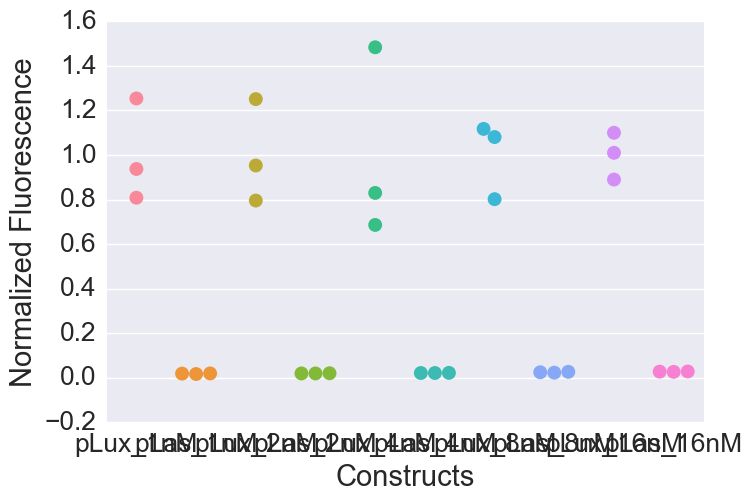

In [57]:
# Make a swarmplot for pLux vs. pLas
sns.swarmplot(x='Constructs', y='Normalized Fluorescence', data=pLux_vs_pLas, size=10)
plt.show()

/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


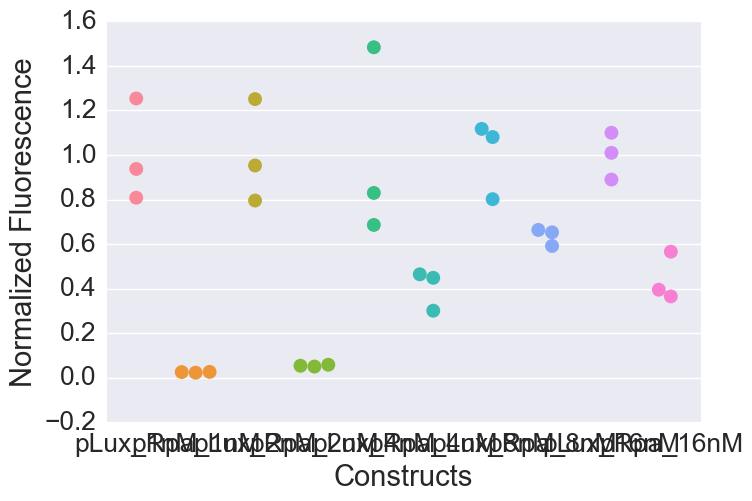

In [58]:
#Make a swarmplot for pLux for pRpa 
sns.swarmplot(x='Constructs', y='Normalized Fluorescence', data=pLux_vs_pRpa, size=10)
plt.show()

The formatting is absolutely atrocious, but we'll fix that in illustrator. This means we have reproduced all of the figures
from the text.